In [ ]:
import datetime
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import pandas as pd

print(tf.__version__)

In [ ]:
%%bash
ls /home/jupyter/heart-failure/*.csv

In [ ]:
%%bash
head -5 /home/jupyter/heart-failure/*.csv

In [119]:
hf_file = '/home/jupyter/heart-failure/scaled-heart.csv'

In [120]:
dtypes = {'Age':int, 'Sex':str, 'ChestPainType':str, 'RestingBP':int, 'Cholesterol':int, 'FastingBS':str,
       'RestingECG':str, 'MaxHR':int, 'ExerciseAngina':str, 'Oldpeak':float, 'ST_Slope':str,
       'HeartDisease':int, 'split':str}

In [121]:
df = pd.read_csv(hf_file,dtype=dtypes)

In [122]:
#split to three files to use the tf.data workflow

split = df.split.unique()

col = list(df.columns)
keep_col = col.pop(col.index('split'))

for s in split:
    df[df['split']== s][keep_col].to_csv('/home/jupyter/heart-failure/' + s + '.csv')

In [123]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,split
0,46,M,ASY,140,311,0,Normal,120,Y,1.8,Flat,1,TRAIN
1,62,M,ATA,120,254,0,LVH,93,Y,0.0,Flat,1,TRAIN
2,51,M,NAP,110,175,0,Normal,123,N,0.6,Up,0,TRAIN
3,62,F,TA,140,0,1,Normal,143,N,0.0,Flat,1,TRAIN
4,44,M,ASY,150,412,0,Normal,170,N,0.0,Up,0,TRAIN


In [124]:
import seaborn as sns

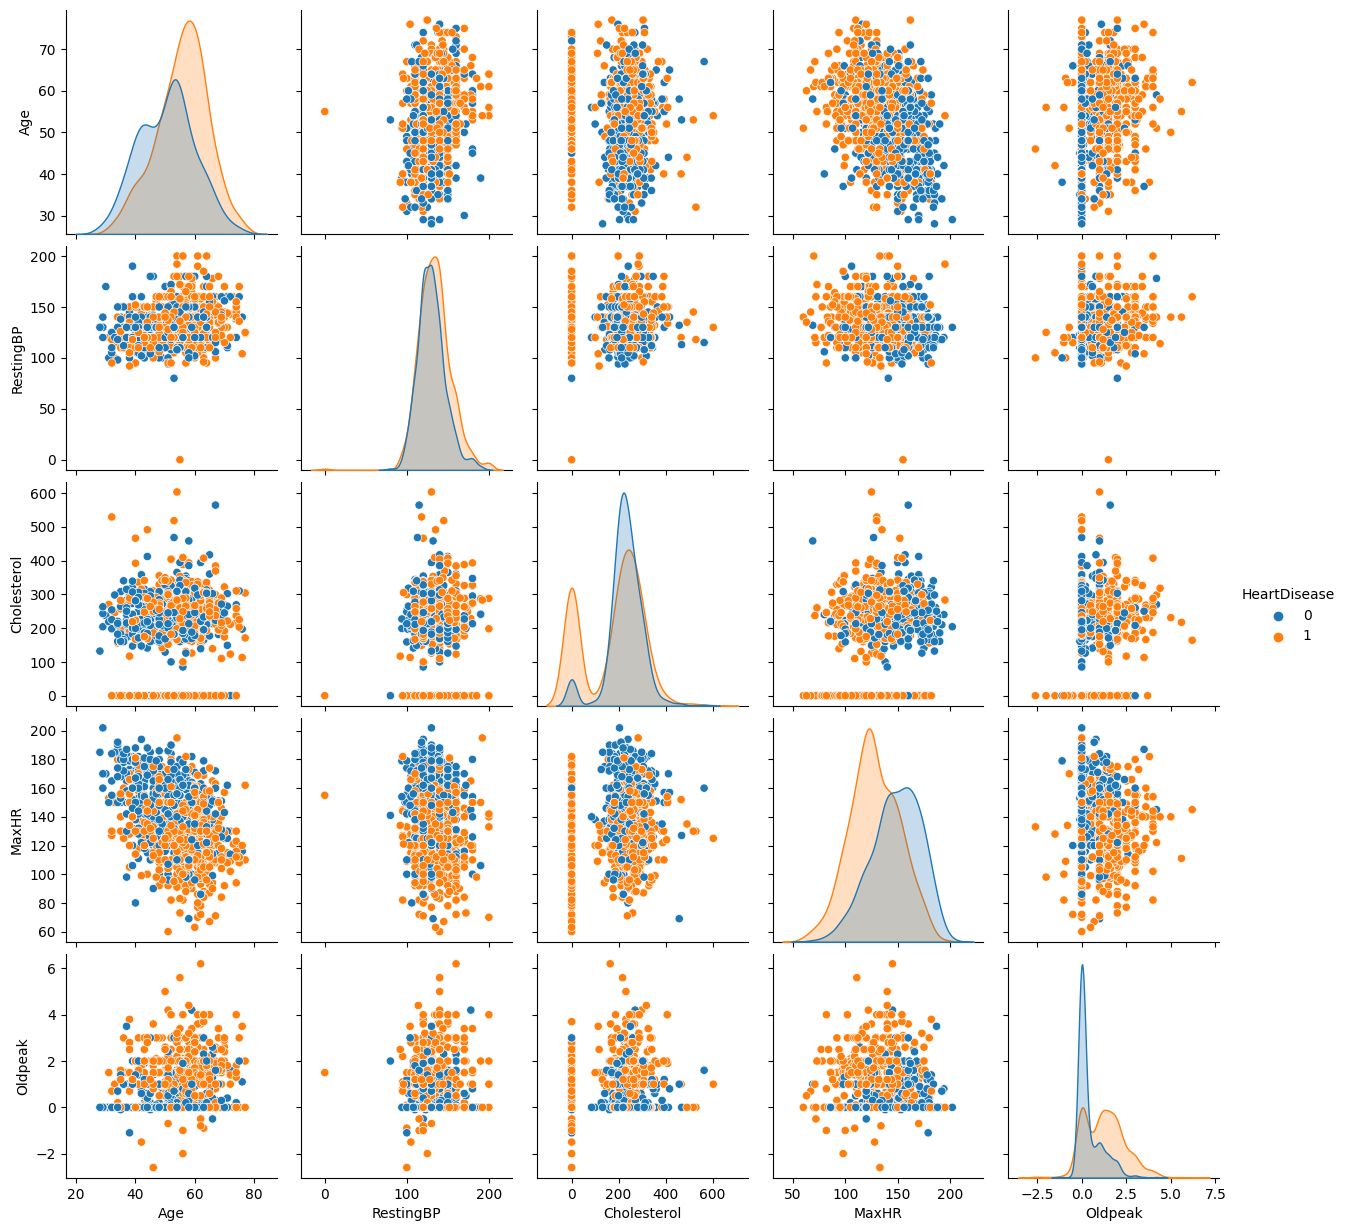

In [125]:
sns.pairplot(df,hue='HeartDisease')

In [126]:
df['count'] = 1

In [127]:
df_cat = df[CATEGORICAL_COLUMNS + [LABEL_COLUMN]+['count']].drop('split',axis=1)
df_cat = df_cat.groupby(list(df_cat.columns[:-1])).sum().reset_index()

In [128]:
df_cat

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease,count
0,F,ASY,0,LVH,N,Down,1,2
1,F,ASY,0,LVH,N,Flat,0,5
2,F,ASY,0,LVH,N,Flat,1,4
3,F,ASY,0,LVH,N,Up,0,3
4,F,ASY,0,LVH,N,Up,1,2
...,...,...,...,...,...,...,...,...
201,M,TA,1,Normal,N,Flat,1,1
202,M,TA,1,Normal,N,Up,1,2
203,M,TA,1,Normal,Y,Flat,1,1
204,M,TA,1,ST,N,Down,1,1


In [129]:
def plot_cat(cat):
    sns.barplot(x=cat,y='count',hue='HeartDisease',data=df_cat)

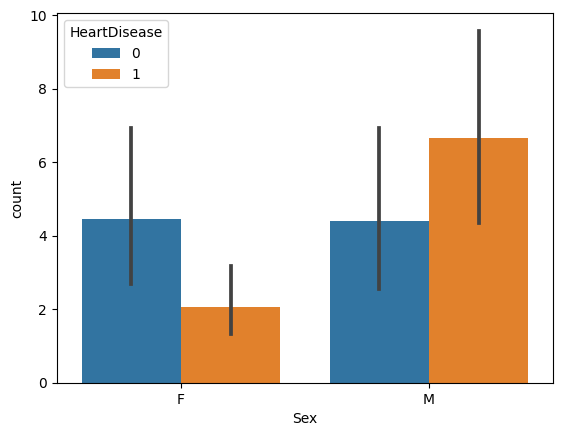

In [130]:
plot_cat(df_cat.columns[0])

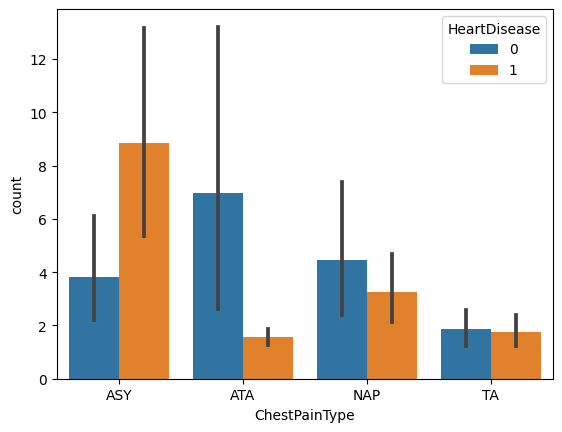

In [131]:
plot_cat(df_cat.columns[1])

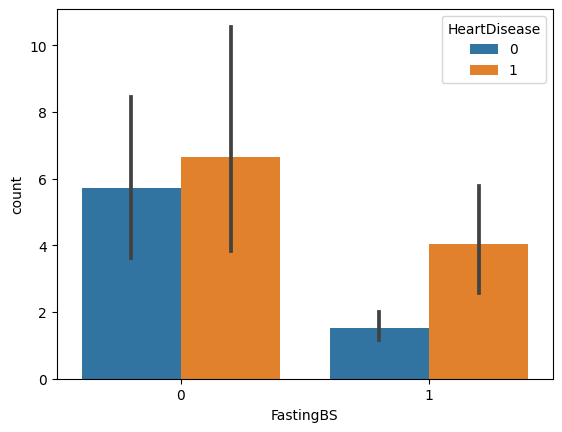

In [132]:
plot_cat(df_cat.columns[2])

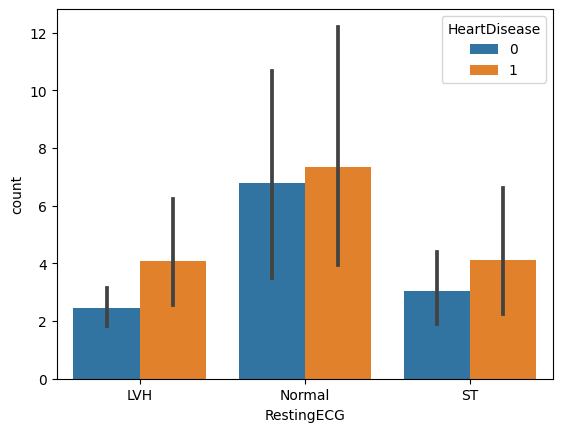

In [133]:
plot_cat(df_cat.columns[3])

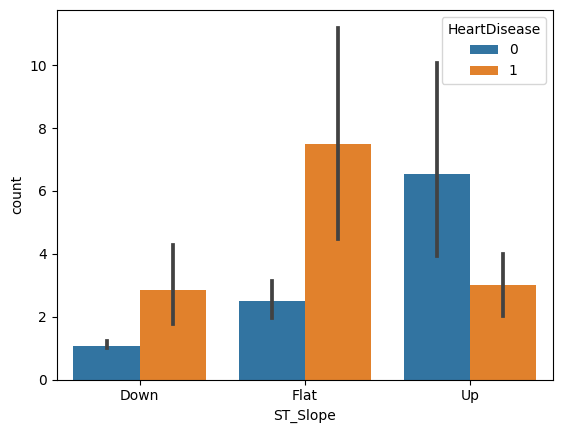

In [134]:
plot_cat(df_cat.columns[5])

<AxesSubplot:xlabel='Age', ylabel='Count'>

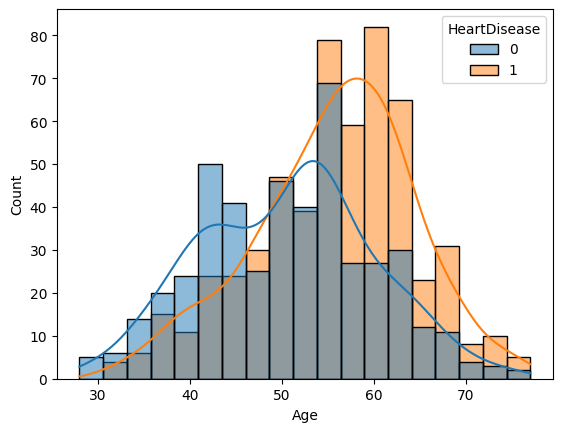

In [145]:
#deciding on binning for age
sns.histplot(data=df,x='Age',hue='HeartDisease',kde=True)

In [108]:
num_columns = [i for i in dtypes if dtypes[i] == int]
cat_columns = [i for i in dtypes if dtypes[i] == str]

In [109]:
dtype_map = {int:0,str:['null'],float:0.0}

In [50]:
#[dtype_map[dtypes[i]] for i in dtypes]

In [49]:
# Determine CSV, label, and key columns
CSV_COLUMNS = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease']

LABEL_COLUMN = "HeartDisease"

NUMERICAL_COLUMNS = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
CATEGORICAL_COLUMNS = ['Sex','ChestPainType', 'FastingBS','RestingECG','ExerciseAngina','ST_Slope']

# Set default values for each CSV column.
# Treat is_male and plurality as strings.
DEFAULTS = [0,['null'],['null'], 0,0,['null'], ['null'], 0, ['null'], 0.0, ['null'], 0, ['null']]

In [137]:
def features_and_labels(row_data):
    """Splits features and labels from feature dictionary.

    Args:
        row_data: Dictionary of CSV column names and tensor values.
    Returns:
        Dictionary of feature tensors and label tensor.
    """
    label = row_data.pop(LABEL_COLUMN)

    return row_data, label  # features, label


def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    """Loads dataset using the tf.data API from CSV files.

    Args:
        pattern: str, file pattern to glob into list of files.
        batch_size: int, the number of examples per batch.
        mode: tf.estimator.ModeKeys to determine if training or evaluating.
    Returns:
        `Dataset` object.
    """
    # Make a CSV dataset
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=pattern,
        batch_size=batch_size,
        column_names=CSV_COLUMNS,
        column_defaults=DEFAULTS,
    )

    # Map dataset to features and label
    dataset = dataset.map(map_func=features_and_labels)  # features, label

    # Shuffle and repeat for training
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=100).repeat()

    # Take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

In [ ]:
def transform(inputs, nembeds):
    """Creates dictionary of transformed inputs.

    Returns:
        Dictionary of transformed Tensors
    """

    deep = {}
    wide = {}

    buckets = {
        "Age": np.arange(40, 50, 60, 70, 80, 1).tolist(),
        "gestation_weeks": np.arange(17, 47, 1).tolist(),
    }
    bucketized = {}

    for numeric_column in NUMERICAL_COLUMNS:
        deep[numeric_column] = inputs[numeric_column]
        bucketized[numeric_column] = tf.keras.layers.Discretization(
            buckets[numeric_column]
        )(inputs[numeric_column])
        wide[f"btk_{numeric_column}"] = tf.keras.layers.CategoryEncoding(
            num_tokens=len(buckets[numeric_column]) + 1, output_mode="one_hot"
        )(bucketized[numeric_column])

    crossed = tf.keras.layers.experimental.preprocessing.HashedCrossing(
        num_bins=len(buckets["mother_age"]) * len(buckets["gestation_weeks"])
    )((bucketized["mother_age"], bucketized["gestation_weeks"]))

    deep["age_gestation_embeds"] = tf.keras.layers.Flatten()(
        tf.keras.layers.Embedding(
            input_dim=len(buckets["mother_age"])
            * len(buckets["gestation_weeks"]),
            output_dim=nembeds,
        )(crossed)
    )

    vocab = {
        "is_male": ["True", "False", "Unknown"],
        "plurality": [
            "Single(1)",
            "Twins(2)",
            "Triplets(3)",
            "Quadruplets(4)",
            "Quintuplets(5)",
            "Multiple(2+)",
        ],
    }

    for categorical_column in CATEGORICAL_COLUMNS:
        wide[categorical_column] = tf.keras.layers.StringLookup(
            vocabulary=vocab[categorical_column], output_mode="one_hot"
        )(inputs[categorical_column])

    return wide, deep